<a href="https://colab.research.google.com/github/m-aliabbas/EvolutionaryComputing/blob/master/Resnet18LastLayerPretrainTuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import fastai
from fastai.vision import *
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
from zipfile import ZipFile 
def unZip(file_name):
  with ZipFile(file_name, 'r') as zip: 
      zip.extractall() 
      print('Done!') 

In [0]:
file_name = '/content/drive/chestXRay.zip'

In [0]:
path="/content/drive/My Drive/"
file_name=path+'chestXRay.zip'

In [0]:
unZip(file_name)

Done!


In [0]:
!ls chest_xray

test  train  val


In [0]:
!ls

chest_xray  chest_xray.zip  dataset1  drive  __MACOSX  sample_data


In [0]:
unZip('chest_xray.zip')

Done!


In [0]:
!ls chest_xray

test  train  val


In [0]:
import glob
import cv2
import numpy as np
%matplotlib inline
filesPos= sorted(glob.glob('chest_xray/train/NORMAL/*.jpeg'))
filesNeg=sorted(glob.glob('chest_xray/train/PNEUMONIA/*.jpeg'))

In [0]:
print(len(filesPos),len(filesNeg))

1341 3875


In [0]:
from fastai import *
import shutil
def copyfiles(filesName,dest):
  c=0
  for file in filesName:
    shutil.copy(file, dest)
    c+=1
  print("Copied "+str(c))

In [0]:
!mkdir dataset1

In [0]:
!mkdir dataset1/train

In [0]:
!ls dataset1

train


In [0]:
!mkdir dataset1/train/PNEUMONIA
!mkdir dataset1/train/NORMAL

In [0]:
!ls dataset1/train/

NORMAL	PNEUMONIA


In [0]:
filesNeg=filesNeg[:1340]

In [0]:
import random 
random.seed(3000)
random.shuffle(filesNeg)
random.shuffle(filesPos)

In [0]:
!ls chest_xray

test  train  val


In [0]:
copyfiles(filesPos,'dataset1/train/NORMAL')

Copied 1341


In [0]:
copyfiles(filesNeg,'dataset1/train/PNEUMONIA')

Copied 1340


In [0]:
!mkdir dataset1/valid

In [0]:
!mkdir dataset1/test

In [0]:
!cp -r chest_xray/val dataset1/

In [0]:
!cp -r chest_xray/test dataset1/

In [0]:
!rm -rf dataset1/valid

In [0]:
!mv dataset1/val dataset1/valid

In [0]:
np.random.seed(1234)
path='dataset1'
data = ImageDataBunch.from_folder(path,
        ds_tfms=get_transforms(do_flip=True,max_lighting=0.1),
        seed=1234,
        valid_pct=0.2,                          
        size=224,
        num_workers=8,
        bs=32,
        test="test")

In [0]:
data.classes

['NORMAL', 'PNEUMONIA']

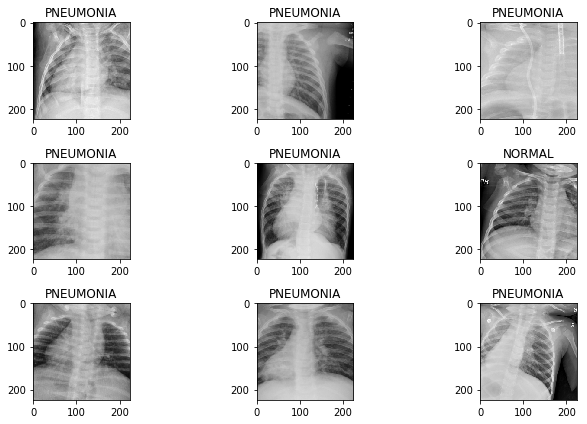

In [0]:
data.show_batch(rows=3, figsize=(10,6), hide_axis=False)

In [0]:
data

ImageDataBunch;

Train: LabelList (1584 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: dataset1;

Valid: LabelList (396 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,NORMAL,PNEUMONIA,PNEUMONIA
Path: dataset1;

Test: LabelList (624 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: dataset1

In [0]:

import torch 
import torchvision
resnet18PT = torchvision.models.resnet18(pretrained=True)

In [0]:
num_ftrs = resnet18PT.fc.in_features
resnet18PT.fc=nn.Sequential(
    
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 128),
    nn.Dropout(0.5),
    nn.Linear(128, 2),
)

In [0]:
resnet18PT=resnet18PT.cuda()

In [0]:


learn = Learner(data, resnet18PT, metrics=[error_rate, accuracy,])

In [0]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (2657 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: dataset1;

Valid: LabelList (664 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NORMAL,PNEUMONIA,NORMAL,PNEUMONIA,NORMAL
Path: dataset1;

Test: LabelList (624 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: dataset1, model=ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(


In [0]:
learn.freeze_to(40)

In [43]:
from fastai.callbacks import *
learn.fit_one_cycle(15,0.0003,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='error_rate')])

/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every imrpovement is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.803378,0.768631,0.549699,0.450301,02:27
1,0.785688,0.666238,0.405120,0.594880,02:24
2,0.710382,0.555130,0.186747,0.813253,02:22
3,0.594781,0.416698,0.099398,0.900602,02:23
4,0.497282,0.322098,0.093373,0.906627,02:22
5,0.392328,0.267047,0.087349,0.912651,02:22
6,0.349130,0.242012,0.084337,0.915663,02:22
7,0.319467,0.225457,0.082831,0.917169,02:22
8,0.302532,0.208086,0.075301,0.924699,02:21
9,0.277520,0.193682,0.070783,0.929217,02:22


Better model found at epoch 0 with error_rate value: 0.5496987700462341.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


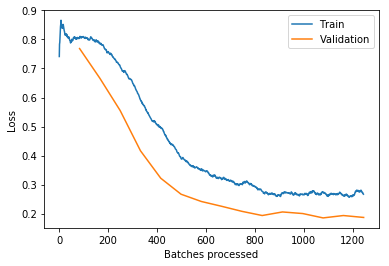

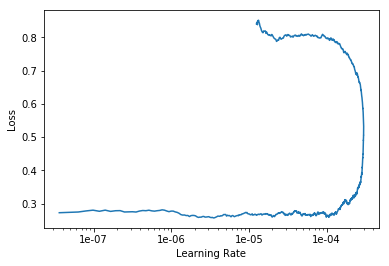

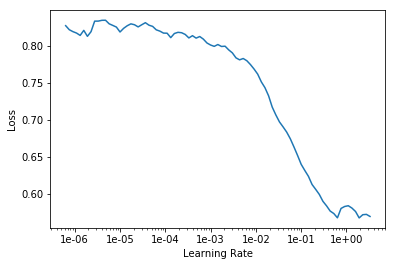

In [44]:
learn.recorder.plot_losses()
learn.recorder.plot(show_momentum=True)
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.save('resnet18LastLayer')

In [46]:
learn.load('resnet18LastLayer')

Learner(data=ImageDataBunch;

Train: LabelList (2657 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: dataset1;

Valid: LabelList (664 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NORMAL,PNEUMONIA,NORMAL,PNEUMONIA,NORMAL
Path: dataset1;

Test: LabelList (624 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: dataset1, model=ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(


In [47]:
learn.fit_one_cycle(10,0.1,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='error_rate')])

/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every imrpovement is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.305711,0.277344,0.117470,0.882530,02:22
1,0.240894,0.574897,0.263554,0.736446,02:21
2,0.243840,1.348765,0.432229,0.567771,02:21
3,0.232444,1.011445,0.263554,0.736446,02:21
4,0.217164,0.128368,0.037651,0.962349,02:21
5,0.190153,0.206241,0.073795,0.926205,02:21
6,0.185152,0.143602,0.048193,0.951807,02:21
7,0.172205,0.119571,0.036145,0.963855,02:21
8,0.147861,0.144636,0.055723,0.944277,02:21
9,0.136588,0.128612,0.042169,0.957831,02:21


Better model found at epoch 0 with error_rate value: 0.11746987700462341.
Better model found at epoch 1 with error_rate value: 0.2635542154312134.
Better model found at epoch 2 with error_rate value: 0.4322289228439331.


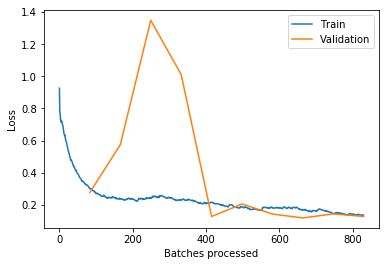

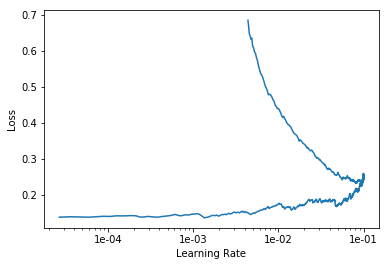

In [48]:
learn.recorder.plot_losses()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


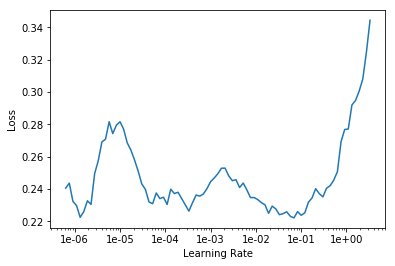

In [49]:
learn.lr_find()
learn.recorder.plot()

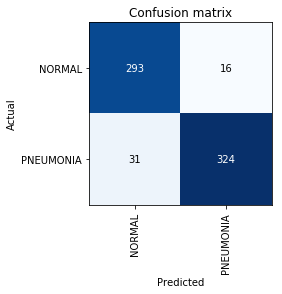

In [0]:
learn.save('model1Resnet')
learn.load('model1Resnet')
learn.unfreeze()
learn.fit_one_cycle(12,max_lr=1e-06,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='error_rate')])
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [51]:
learn.fit_one_cycle(12,max_lr=1e-06)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.249248,0.183389,0.069277,0.930723,02:22
1,0.234663,0.184658,0.063253,0.936747,02:22
2,0.227668,0.177463,0.061747,0.938253,02:22
3,0.221112,0.166478,0.058735,0.941265,02:22
4,0.196610,0.154407,0.054217,0.945783,02:22
5,0.189790,0.151214,0.049699,0.950301,02:22
6,0.188534,0.163777,0.052711,0.947289,02:22
7,0.203217,0.137901,0.048193,0.951807,02:22
8,0.197183,0.155466,0.054217,0.945783,02:22
9,0.185879,0.151963,0.049699,0.950301,02:22


In [0]:
learn.save('Res')

In [59]:
learn.load('Res')

Learner(data=ImageDataBunch;

Train: LabelList (2657 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: dataset1;

Valid: LabelList (664 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NORMAL,PNEUMONIA,NORMAL,PNEUMONIA,NORMAL
Path: dataset1;

Test: LabelList (624 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: dataset1, model=ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


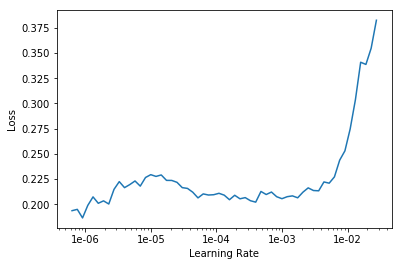

In [60]:
learn.lr_find()
learn.recorder.plot()

In [65]:
learn.fit_one_cycle(20,max_lr=(1e-07),wd=0.25)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.179648,0.151718,0.049699,0.950301,02:22
1,0.195570,0.143730,0.046687,0.953313,02:21
2,0.185873,0.144605,0.046687,0.953313,02:21
3,0.192767,0.140656,0.046687,0.953313,02:21
4,0.198572,0.137602,0.045181,0.954819,02:21
5,0.197313,0.157208,0.052711,0.947289,02:21
6,0.200265,0.151432,0.054217,0.945783,02:21
7,0.195016,0.147474,0.048193,0.951807,02:21
8,0.197415,0.141977,0.046687,0.953313,02:21
9,0.182248,0.139858,0.046687,0.953313,02:21


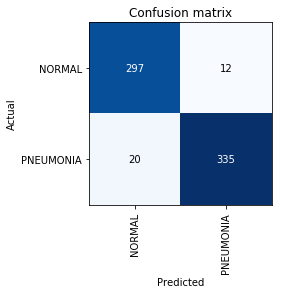

In [56]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4f50132278>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


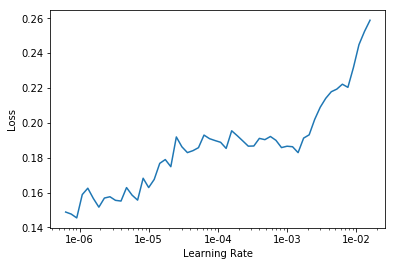

In [68]:
learn.recorder.plot()

In [57]:
conf=interp.confusion_matrix()
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision of Model =",precision,"Recall of Model ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score of Model =',f1)

Precision of Model = 0.9436619718309859 Recall of Model  0.9654178674351584
F1 Score of Model = 0.9544159544159543


In [69]:
learn.fit(7,1e-06)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.182673,0.145785,0.048193,0.951807,02:22
1,0.172978,0.142801,0.045181,0.954819,02:22
2,0.185951,0.139723,0.045181,0.954819,02:22
3,0.195133,0.135398,0.045181,0.954819,02:22
4,0.198789,0.152159,0.048193,0.951807,02:22
5,0.190040,0.146329,0.048193,0.951807,02:22
6,0.197967,0.134823,0.045181,0.954819,02:22


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


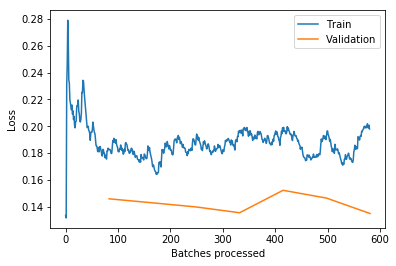

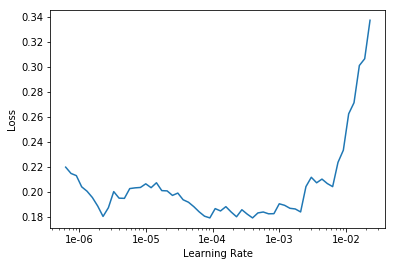

In [70]:
learn.recorder.plot_losses()
learn.lr_find()
learn.recorder.plot()

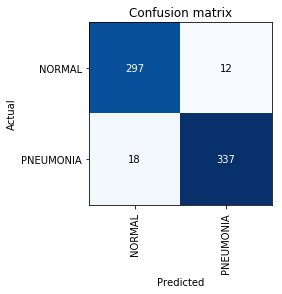

In [71]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [72]:
conf=interp.confusion_matrix()
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision of Model =",precision,"Recall of Model ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score of Model =',f1)

Precision of Model = 0.9492957746478873 Recall of Model  0.9656160458452722
F1 Score of Model = 0.9573863636363636
